In [1]:
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (
    make_scorer, precision_score, recall_score, roc_auc_score, f1_score, accuracy_score, classification_report,
    roc_curve, auc, precision_recall_curve, confusion_matrix)
from scipy.stats.distributions import loguniform
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import seaborn as sns

from lazypredict.Supervised import LazyClassifier

from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline  # combining classifier steps
from sklearn.preprocessing import StandardScaler # scaling features

import numpy as np
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score, make_scorer, precision_score
from hyperopt import space_eval
import pandas as pd
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.base import clone

import statsmodels.api as sm
from scipy.stats import t
from sklearn.linear_model import LinearRegression



### Reasons for dividing models for column and panel

- Difficulty with imputing nan values for panel
- Larger feature space
- Might want to include 'compact radiator type' as that could give indication of equivalent of 'cols' ('width' of panel radiator)


##### Data clean up

In [11]:
df_show = pd.read_csv('Radiators.csv')
df_show = df_show.drop(['Range', 'Manu. Part Number', 'Column Style', 'Cols', 'n coefficient Strategy', 'n coefficient', 'Heat Output Btu/hr (1)', 'Sections / Elements'], axis = 1)

In [12]:
df_show.head()


,Type,Manufacturer,Panel Radiator Type,Material,Height,Width,Heat Output Watts (dT50)
0,Panel,Stelrad,11.00,Steel,300,500,255.00
1,Panel,Stelrad,11.00,Steel,300,1000,509.00
2,Panel,Stelrad,11.00,Steel,300,1500,764.00
3,Panel,Stelrad,11.00,Steel,300,2000,1018.00
4,Panel,Stelrad,11.00,Steel,300,2500,1273.00


In [13]:
df_show = df_show.rename(columns = {'Heat Output Watts (dT50)' : 'Heat_Output', 'Panel Radiator Type' : 'Panel_Radiator_Type' })

In [14]:
df_show = df_show.loc[df_show.Height <= 750]
df_show = df_show.loc[df_show.Height >= 300]
df_show = df_show.loc[df_show.Width <= 1600]
df_show = df_show.loc[df_show.Width >= 400]

In [ ]:
df_show.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2258 entries, 0 to 6167
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Type                 2258 non-null   object 
 1   Manufacturer         2258 non-null   object 
 2   Panel_Radiator_Type  915 non-null    float64
 3   Material             2258 non-null   object 
 4   Height               2258 non-null   int64  
 5   Width                2258 non-null   int64  
 6   Heat_Output          2258 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 141.1+ KB


In [15]:
df_show = df_show.loc[df_show.Type != 'Towel Rail']

In [16]:
df_show

,Type,Manufacturer,Panel_Radiator_Type,Material,Height,Width,Heat_Output
0,Panel,Stelrad,11.00,Steel,300,500,255.00
1,Panel,Stelrad,11.00,Steel,300,1000,509.00
2,Panel,Stelrad,11.00,Steel,300,1500,764.00
6,Panel,Stelrad,11.00,Steel,450,400,302.00
7,Panel,Stelrad,11.00,Steel,450,500,378.00
...,...,...,...,...,...,...,...
6163,Column,Cornel,NaN,Steel,496,926,840.47
6164,Column,Cornel,NaN,Steel,496,1016,924.63
6165,Column,Cornel,NaN,Steel,496,1061,966.57
6166,Column,Cornel,NaN,Steel,496,1151,1050.73


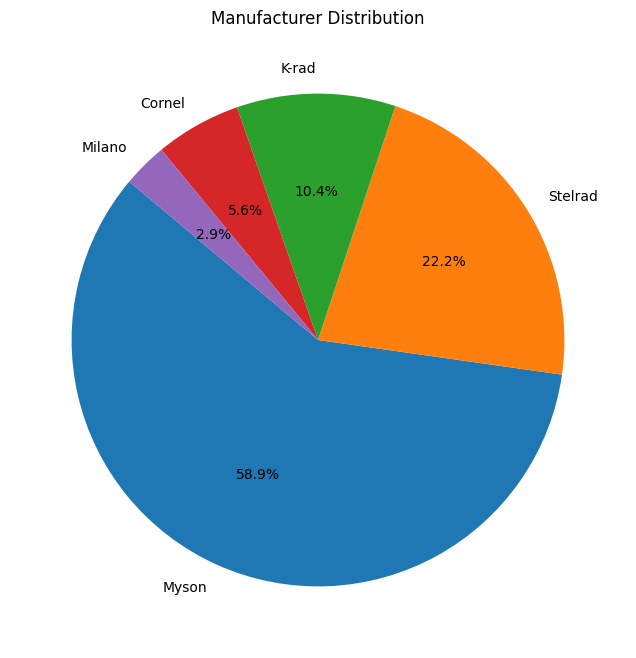

In [17]:

# Calculate the counts for each manufacturer
manufacturer_counts = df_show['Manufacturer'].value_counts()

# Create the pie chart
plt.figure(figsize=(8,8))
plt.pie(manufacturer_counts, labels=manufacturer_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Manufacturer Distribution')
plt.show()


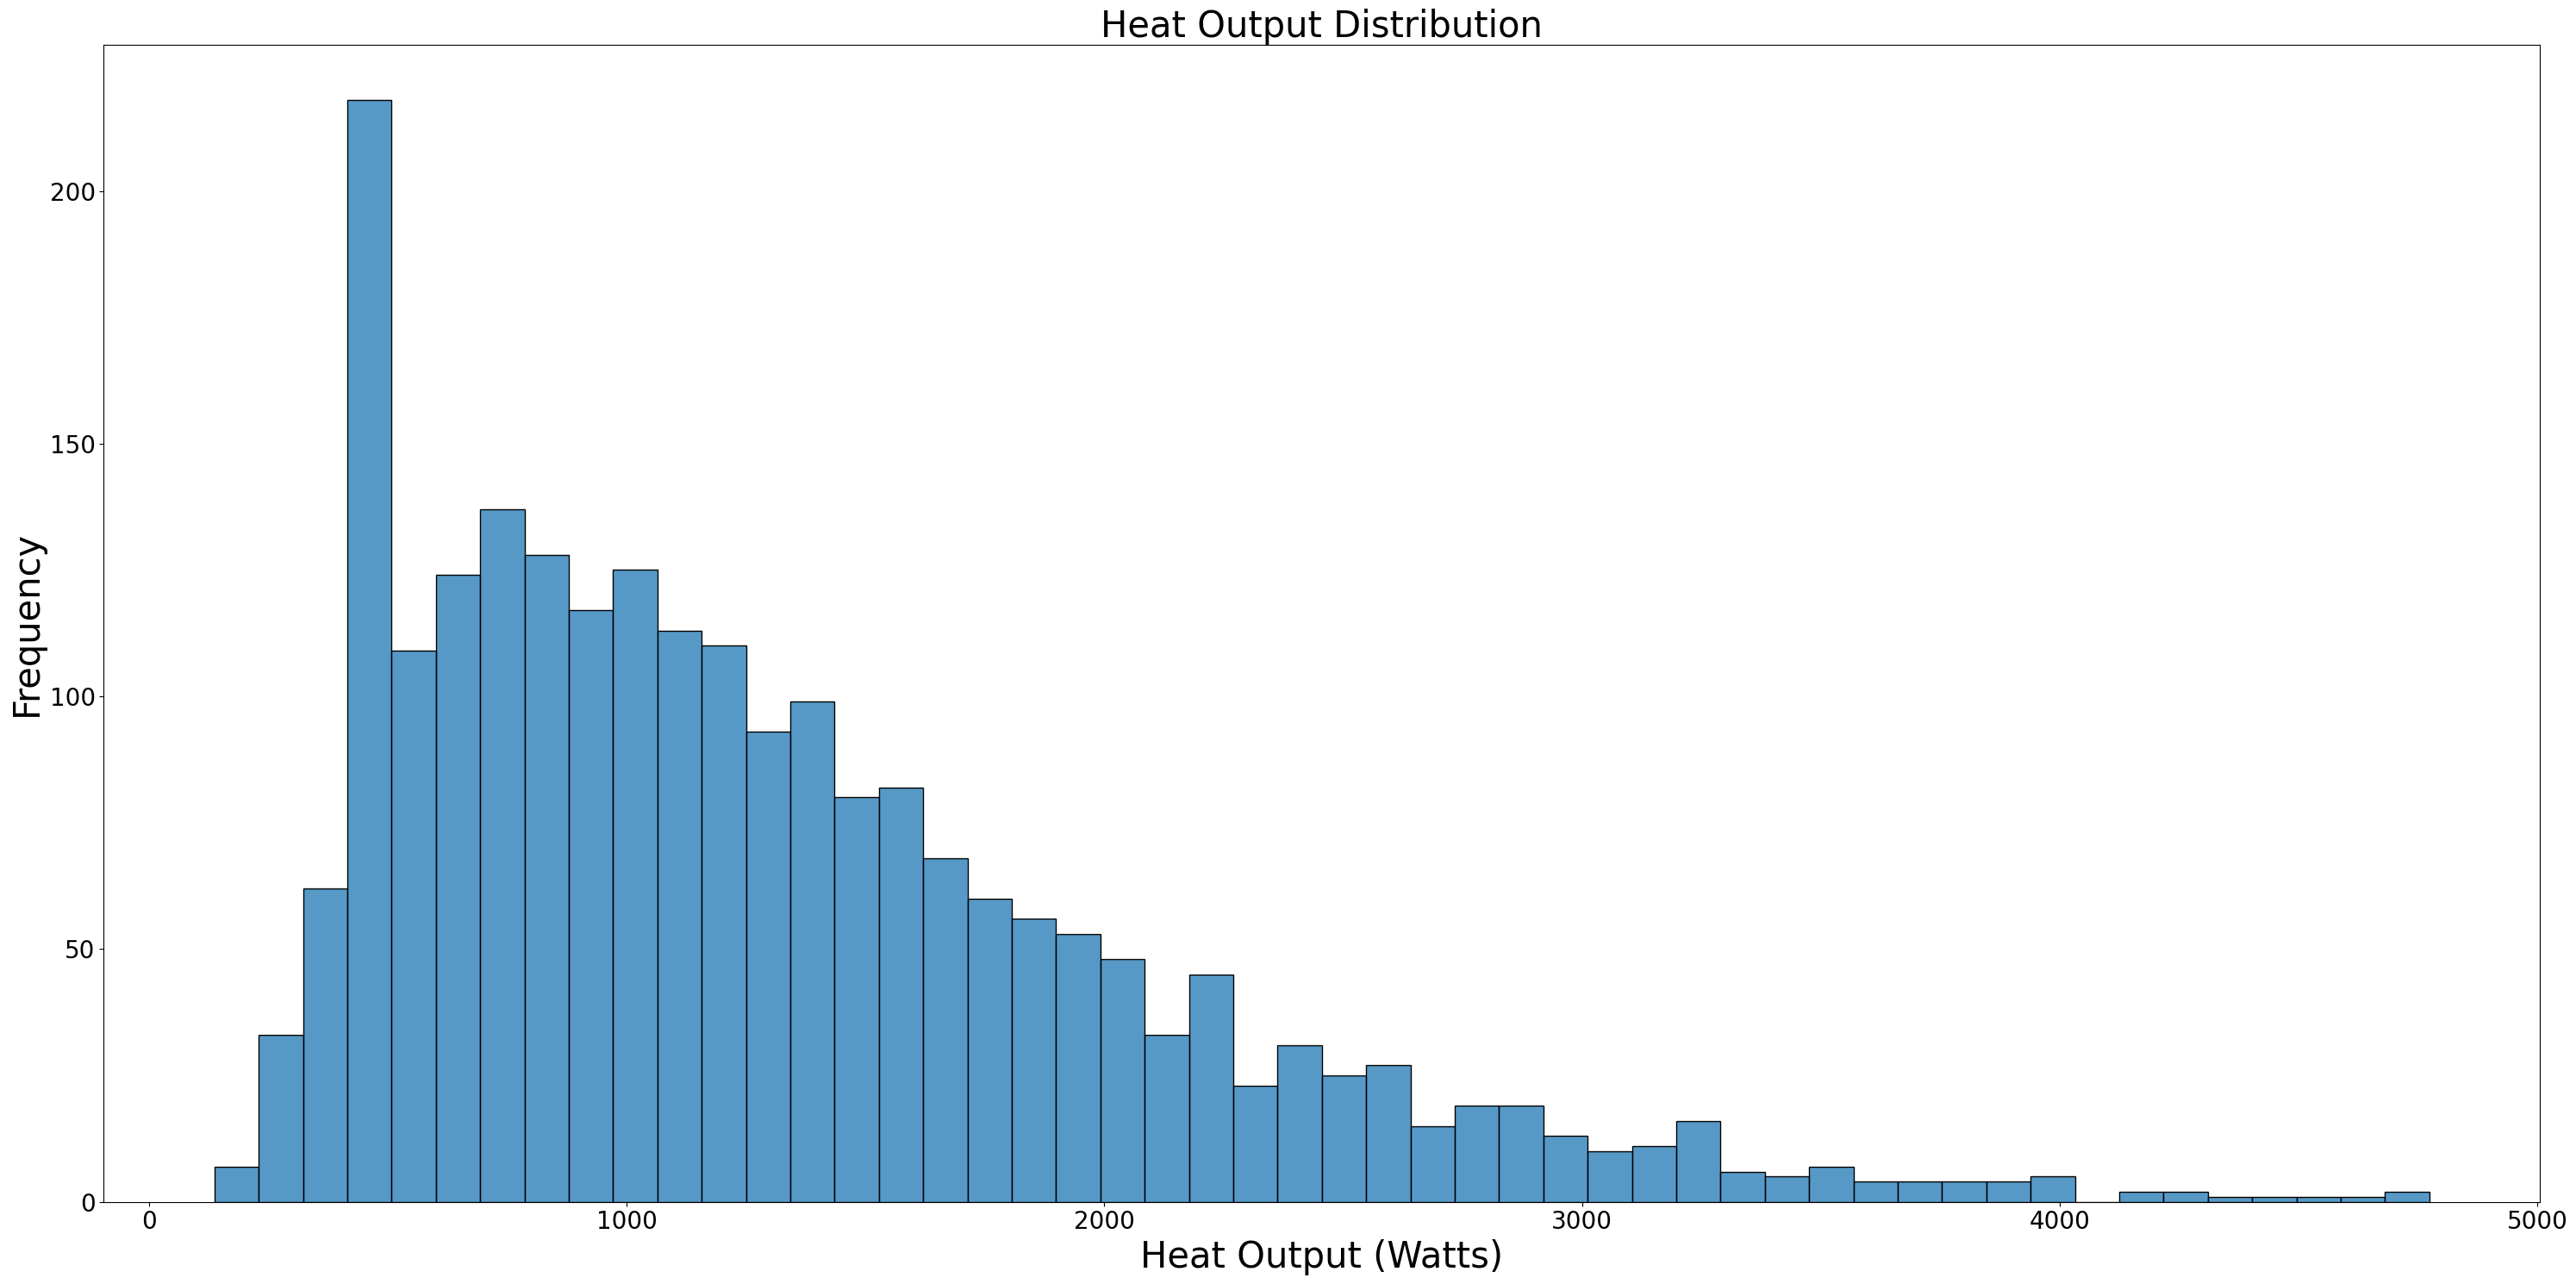

In [9]:
fig, axes = plt.subplots(figsize=(30,15), ncols=1, nrows=1)

sns.histplot(data = df_show['Heat_Output'], bins=50, ax=axes)
axes.set_title('Heat Output Distribution', fontsize=30)
axes.set_ylabel("Frequency", fontsize=30)
axes.set_xlabel("Heat Output (Watts)", fontsize=30)
axes.tick_params(axis='both', which='major', labelsize=20)

plt.tight_layout()
plt.show()

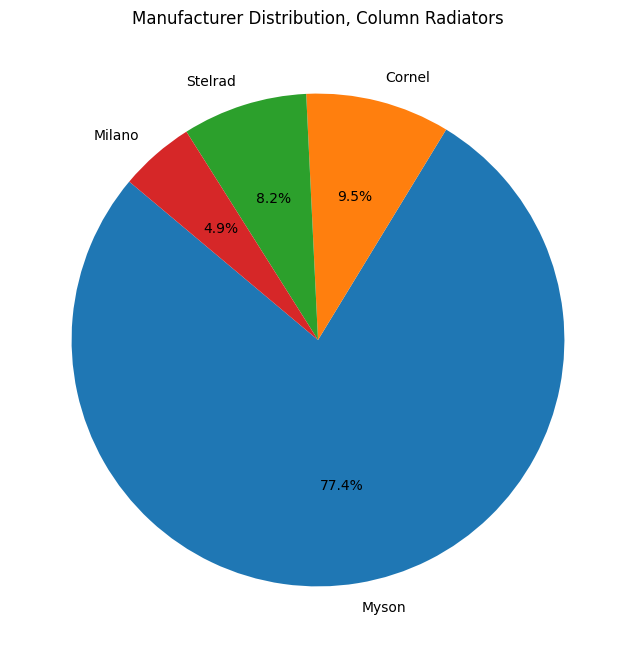

In [10]:
df_show_col = df_show.loc[df_show.Type == 'Column']

# Calculate the counts for each manufacturer
manufacturer_counts = df_show_col['Manufacturer'].value_counts()

# Create the pie chart
plt.figure(figsize=(8,8))
plt.pie(manufacturer_counts, labels=manufacturer_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Manufacturer Distribution, Column Radiators')
plt.show()


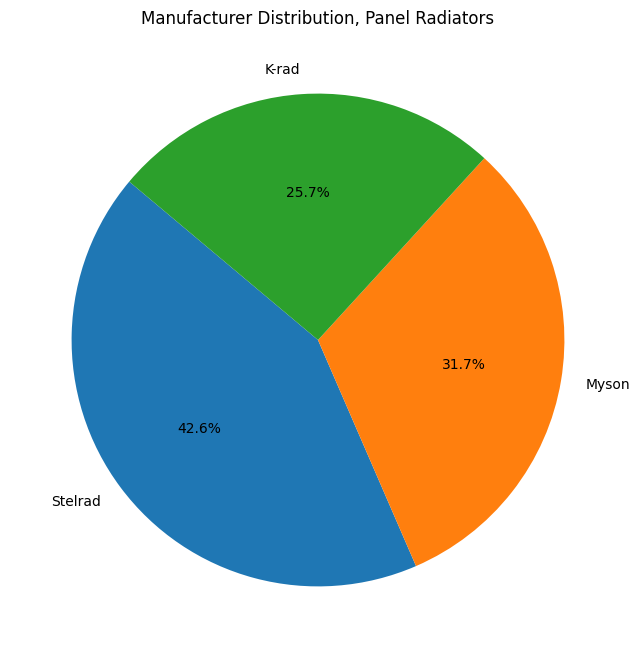

In [11]:
df_show_panel = df_show.loc[df_show.Type == 'Panel']

# Calculate the counts for each manufacturer
manufacturer_counts = df_show_panel['Manufacturer'].value_counts()

# Create the pie chart
plt.figure(figsize=(8,8))
plt.pie(manufacturer_counts, labels=manufacturer_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Manufacturer Distribution, Panel Radiators')
plt.show()


In [12]:
df_show = df_show.loc[df_show.Type == 'Panel']

In [13]:
df_show = df_show.drop('Type', axis = 1)

Radiator Type = Panel
Panel Radiator Type = 33
Material = 'Steel'
Height = 500
Width = 1000

Results:



In [14]:
df_show = df_show.loc[df_show.Height == 500]
df_show = df_show.loc[df_show.Panel_Radiator_Type == 33.00]
df_show = df_show.loc[df_show.Width == 1000]

In [15]:
df_show

,Manufacturer,Panel_Radiator_Type,Material,Height,Width,Heat_Output
204,Stelrad,33.00,Steel,500,1000,2056
465,Stelrad,33.00,Steel,500,1000,2169
789,Myson,33.00,Steel,500,1000,2035
5362,K-rad,33.00,Steel,500,1000,2176
5738,Stelrad,33.00,Steel,500,1000,2017


In [16]:
Value = 2108.74828052
Error = 0.0244*Value
print(Error)

51.453458044688006


Warmur Prediction = 2109 ± 51 Watts

In [71]:
df = pd.read_csv('Radiators.csv')

In [72]:
df.head()

,Type,Manufacturer,Range,Panel Radiator Type,Column Style,Material,Height,Width,Sections / Elements,Cols,Manu. Part Number,Heat Output Watts (dT50),Heat Output Btu/hr (1),n coefficient Strategy,n coefficient
0,Panel,Stelrad,Stelrad Compact,11.00,NaN,Steel,300,500,15.00,NaN,143650,255.00,870,Default,1.30
1,Panel,Stelrad,Stelrad Compact,11.00,NaN,Steel,300,1000,30.00,NaN,143651,509.00,1737,Default,1.30
2,Panel,Stelrad,Stelrad Compact,11.00,NaN,Steel,300,1500,45.00,NaN,143652,764.00,2608,Default,1.30
3,Panel,Stelrad,Stelrad Compact,11.00,NaN,Steel,300,2000,60.00,NaN,143653,1018.00,3474,Default,1.30
4,Panel,Stelrad,Stelrad Compact,11.00,NaN,Steel,300,2500,75.00,NaN,143654,1273.00,4345,Default,1.30


In [73]:
df_new = df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6172 entries, 0 to 6171
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Type                      6172 non-null   object 
 1   Manufacturer              6172 non-null   object 
 2   Range                     6172 non-null   object 
 3   Panel Radiator Type       1404 non-null   float64
 4   Column Style              4675 non-null   object 
 5   Material                  6172 non-null   object 
 6   Height                    6172 non-null   int64  
 7   Width                     6172 non-null   int64  
 8   Sections / Elements       5014 non-null   float64
 9   Cols                      4675 non-null   float64
 10  Manu. Part Number         5980 non-null   object 
 11  Heat Output Watts (dT50)  6172 non-null   float64
 12  Heat Output Btu/hr (1)    1849 non-null   object 
 13  n coefficient Strategy    1157 non-null   object 
 14  n coeffi

In [74]:
df = df.drop(['Range','Manufacturer','Material', 'Panel Radiator Type','Manu. Part Number','Heat Output Btu/hr (1)','n coefficient Strategy', 'n coefficient'], axis = 1)

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6172 entries, 0 to 6171
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Type                      6172 non-null   object 
 1   Column Style              4675 non-null   object 
 2   Height                    6172 non-null   int64  
 3   Width                     6172 non-null   int64  
 4   Sections / Elements       5014 non-null   float64
 5   Cols                      4675 non-null   float64
 6   Heat Output Watts (dT50)  6172 non-null   float64
dtypes: float64(3), int64(2), object(2)
memory usage: 337.7+ KB


In [76]:
df = df.loc[df.Type == 'Column']

In [77]:
df = df.drop('Type', axis =1)

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4675 entries, 255 to 6171
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Column Style              4675 non-null   object 
 1   Height                    4675 non-null   int64  
 2   Width                     4675 non-null   int64  
 3   Sections / Elements       4537 non-null   float64
 4   Cols                      4675 non-null   float64
 5   Heat Output Watts (dT50)  4675 non-null   float64
dtypes: float64(3), int64(2), object(1)
memory usage: 255.7+ KB


In [79]:
df = df.rename(columns = {'Sections / Elements': 'Sections_Elements', 'Heat Output Watts (dT50)' : 'Heat', 'Column Style' : 'Column_Style' })

Before performing the EDA, we will remove all data points which are not relevant for Warmur (massive rads).

In [80]:
df = df.loc[df.Height <= 750]
df = df.loc[df.Height >= 300]
df = df.loc[df.Width <= 1600]
df = df.loc[df.Width >= 400]


In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1341 entries, 255 to 6167
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Column_Style       1341 non-null   object 
 1   Height             1341 non-null   int64  
 2   Width              1341 non-null   int64  
 3   Sections_Elements  1281 non-null   float64
 4   Cols               1341 non-null   float64
 5   Heat               1341 non-null   float64
dtypes: float64(3), int64(2), object(1)
memory usage: 73.3+ KB


##### EDA

In [28]:
import random
seed = random.randint(1000,9999)
print(seed)

3851


In [83]:
seed = 3851

In [84]:
df.describe()

,Height,Width,Sections_Elements,Cols,Heat
count,1341.00,1341.00,1281.00,1341.00,1341.00
mean,505.85,986.29,19.77,3.65,1313.36
std,136.80,349.82,7.15,1.45,735.51
min,300.00,400.00,6.00,1.00,202.00
25%,400.00,700.00,13.00,2.00,780.00
50%,500.00,1000.00,20.00,4.00,1135.00
75%,600.00,1272.00,26.00,5.00,1687.00
max,750.00,1600.00,37.00,6.00,4750.00


##### Comments

- std of many of our features and target variable are significant


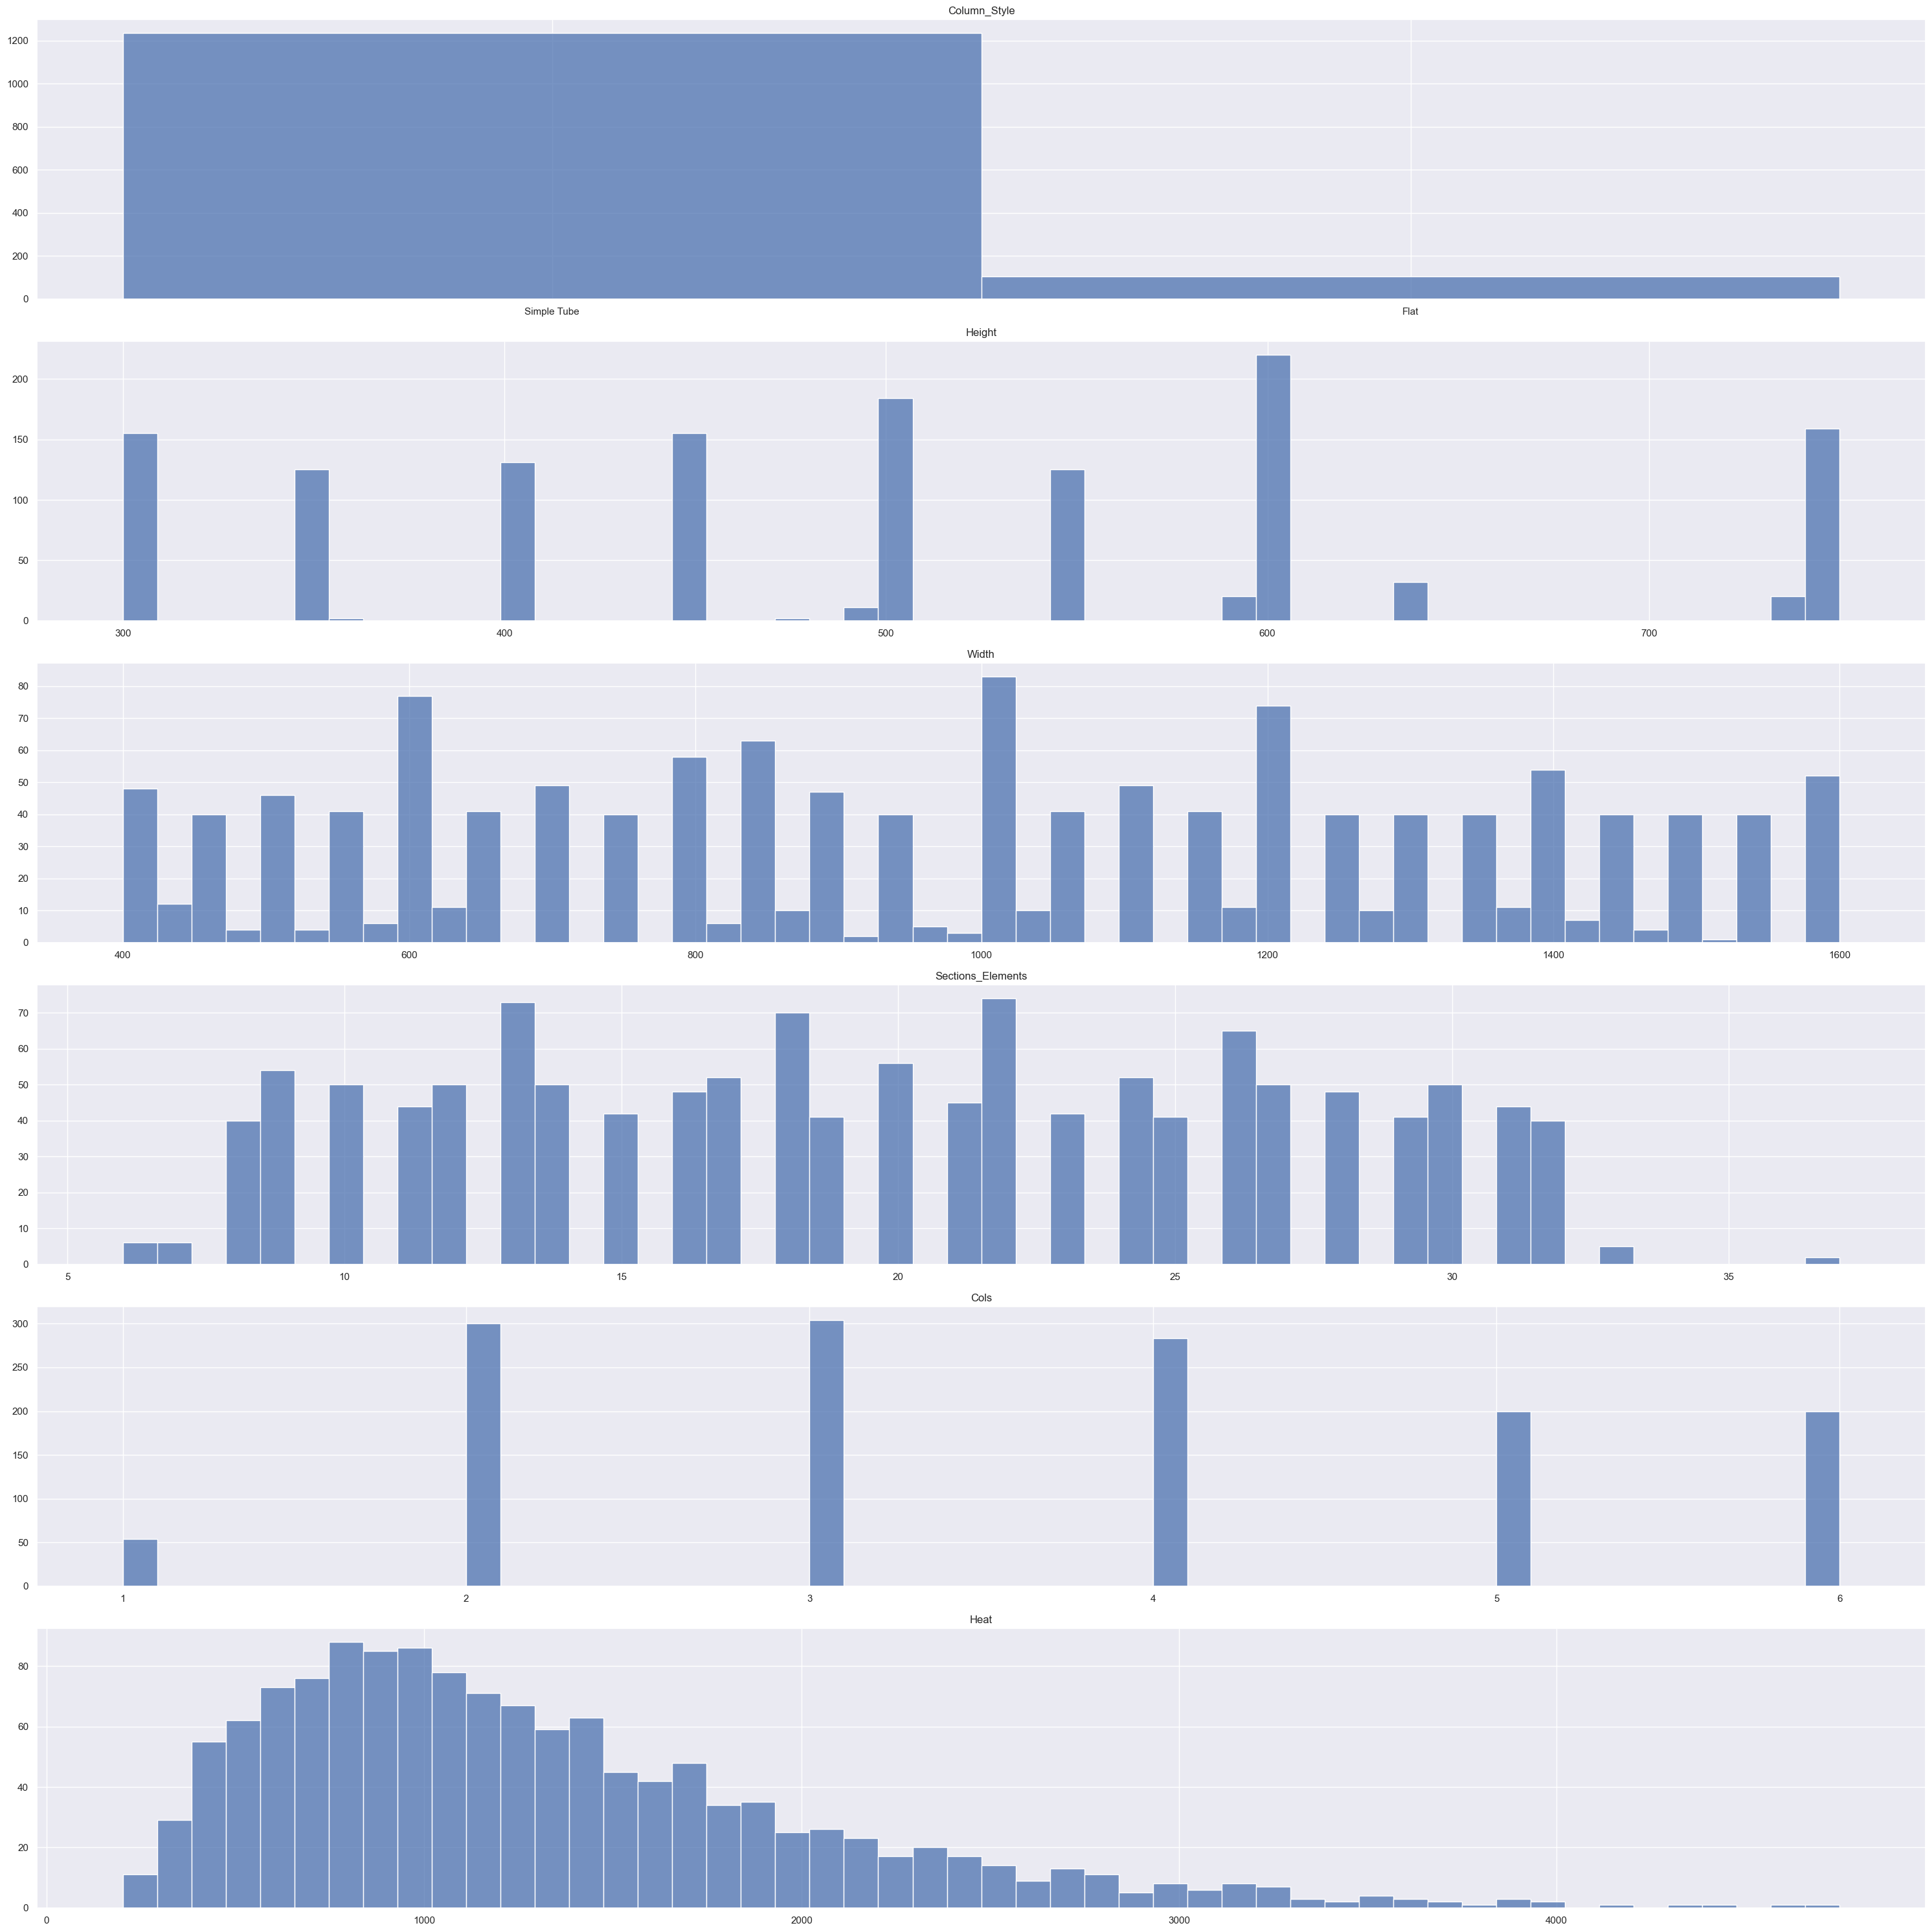

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, axes = plt.subplots(figsize=(30,30), ncols=1, nrows=6)
axes = axes.flatten()

for i, ax in enumerate(axes):
    sns.histplot(data = df.iloc[:, i], bins=50, ax=ax)
    ax.set_title(df.iloc[:,i].name)
    ax.set_ylabel("")
    ax.set_xlabel("")

plt.tight_layout()
plt.show()

##### Comments

- Heat strongly skewed to the left. Might have to consider applying transform here (like box cox)
- Height, Width and Sections_Elements slightly skewed to the left, but quite even generally
- Cols evenly distributed, apart from cols = 1, for which there are very few data points
- Column style very imbalanced - very few type 'flat' in dataset

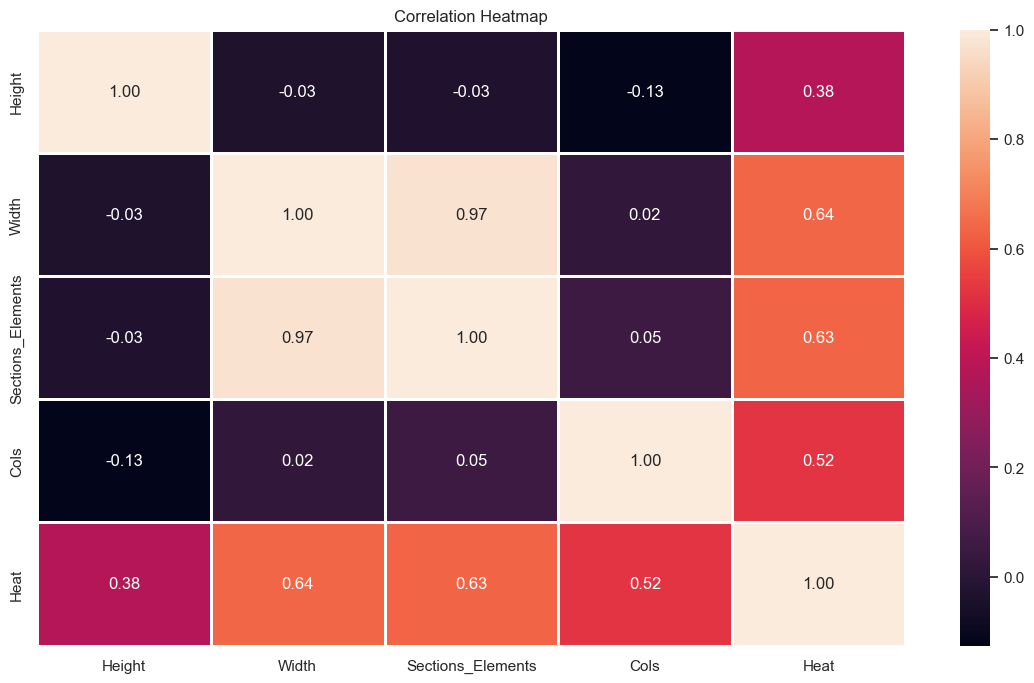

In [86]:
# Or without droping the output directly, easy to see all pairs
df_num = df.drop('Column_Style', axis = 1)

sns.set(rc={'figure.figsize': (14, 8)})
sns.heatmap(df_num.corr(), annot = True, fmt = '.2f', linewidths = 2)
plt.title("Correlation Heatmap")
plt.show()

#### Comments
- Sections_elements and width strongly correlated. Will remove one of them.
- No strong correlation coefficients between any two other feature variables, which makes sense. No strong correlations between target variable and any feature variable.

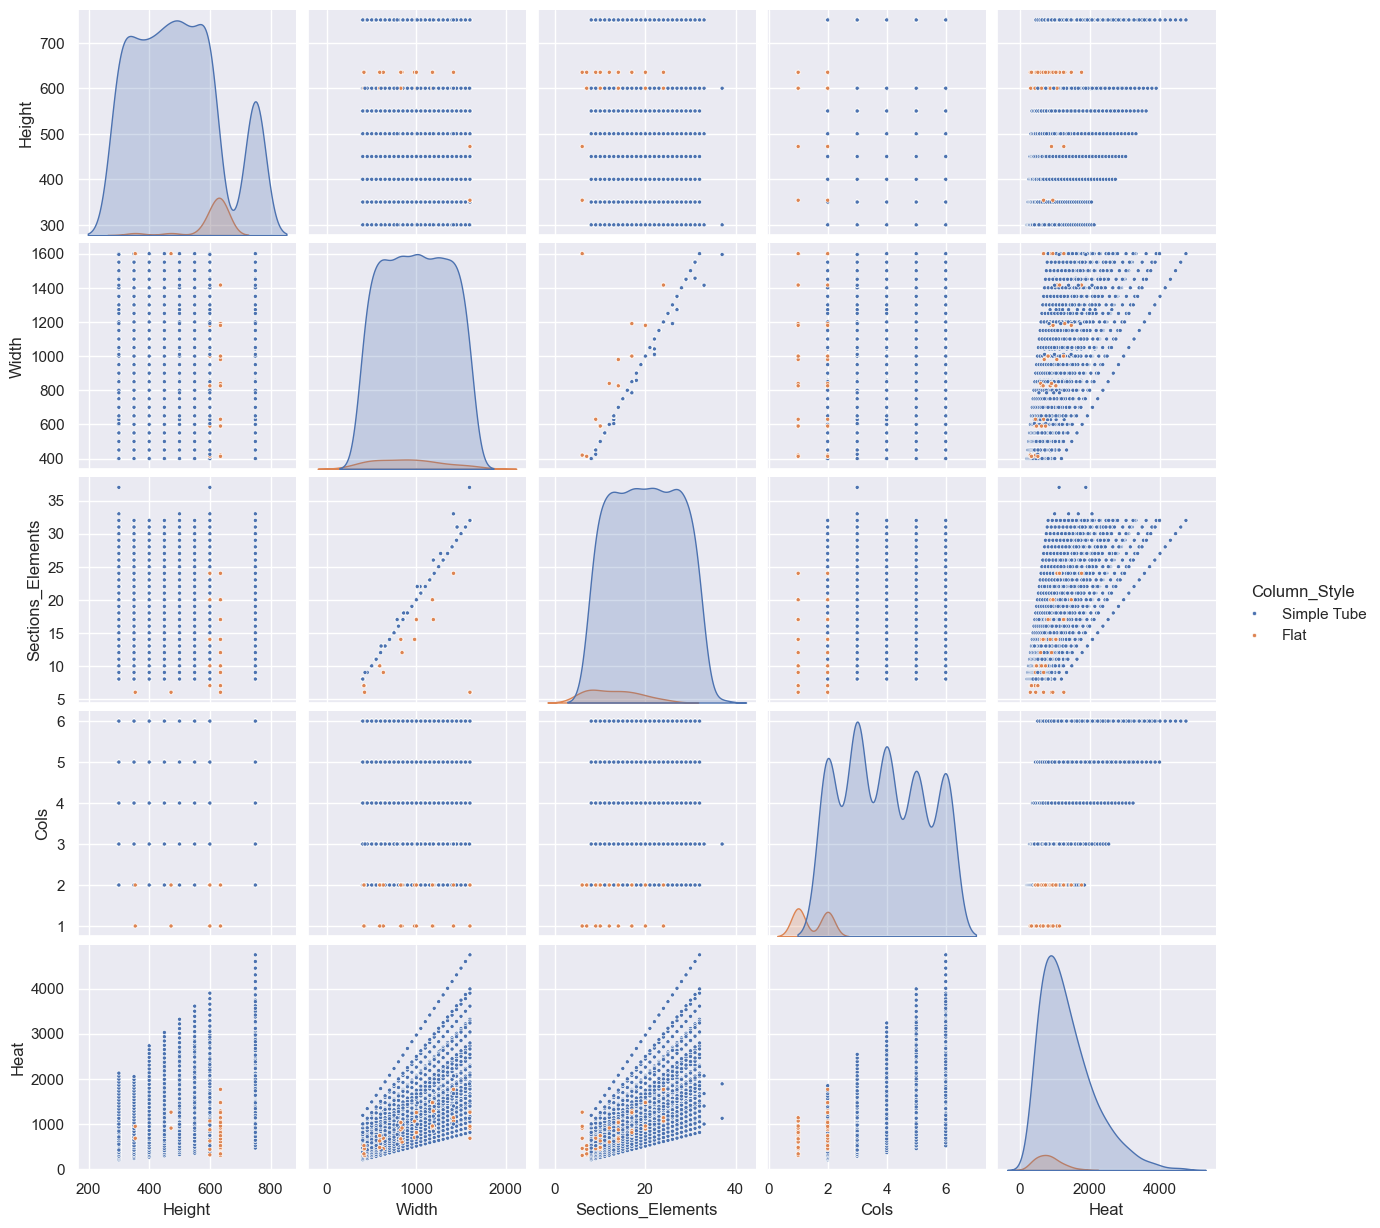

In [64]:
sns.set(rc={'figure.figsize': (14, 8)})
sns.pairplot(df, hue = 'Column_Style', markers=".")
plt.show()

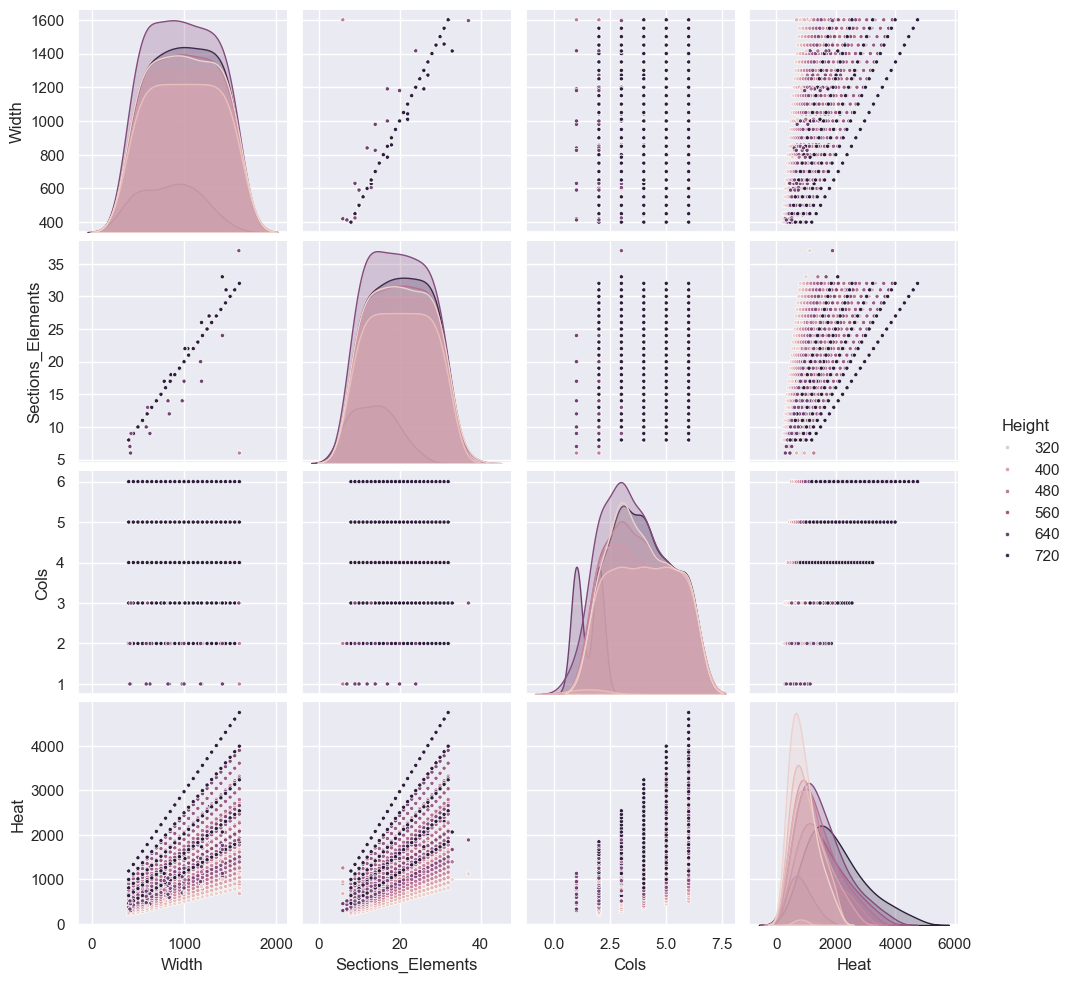

In [65]:
sns.set(rc={'figure.figsize': (14, 8)})
sns.pairplot(df_num, hue='Height', markers=".")
plt.show()

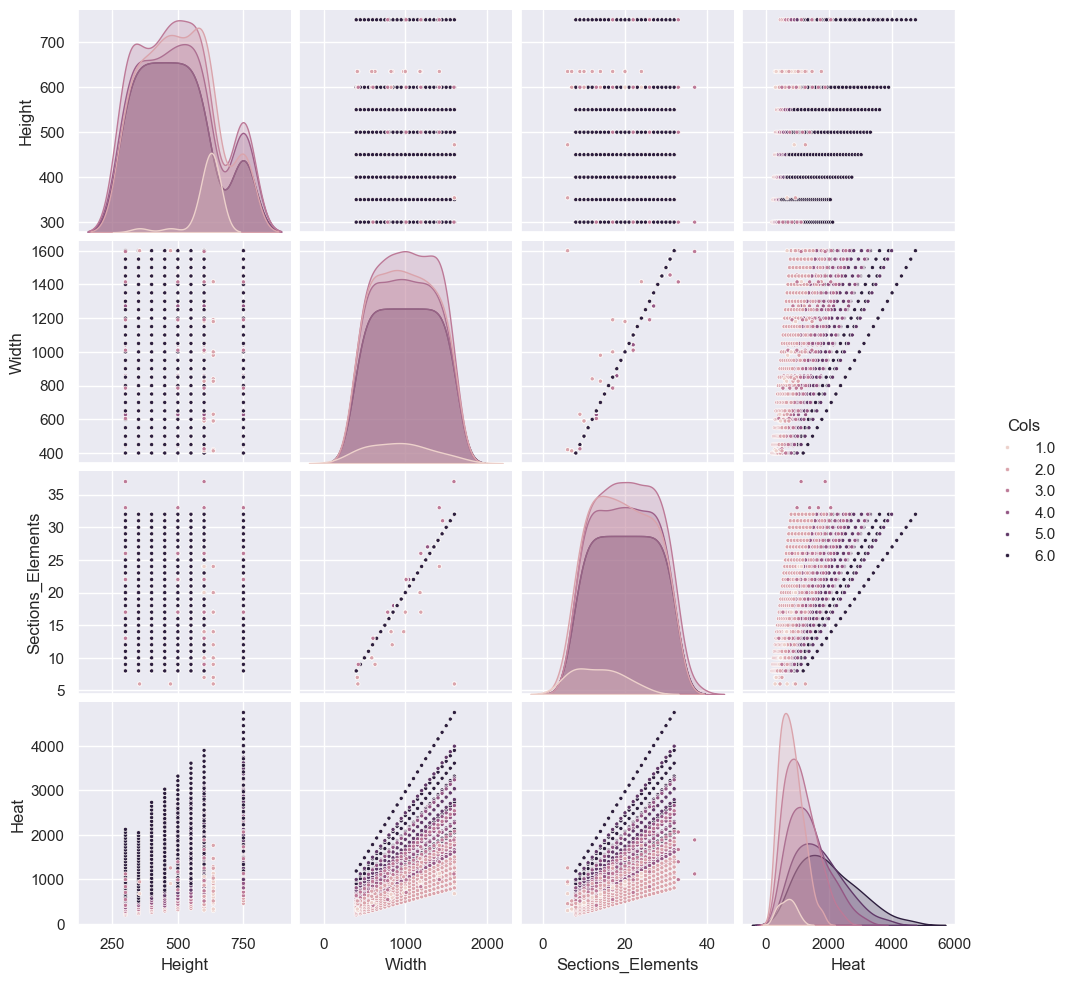

In [66]:
sns.set(rc={'figure.figsize': (14, 8)})
sns.pairplot(df_num, hue='Cols', markers=".")
plt.show()

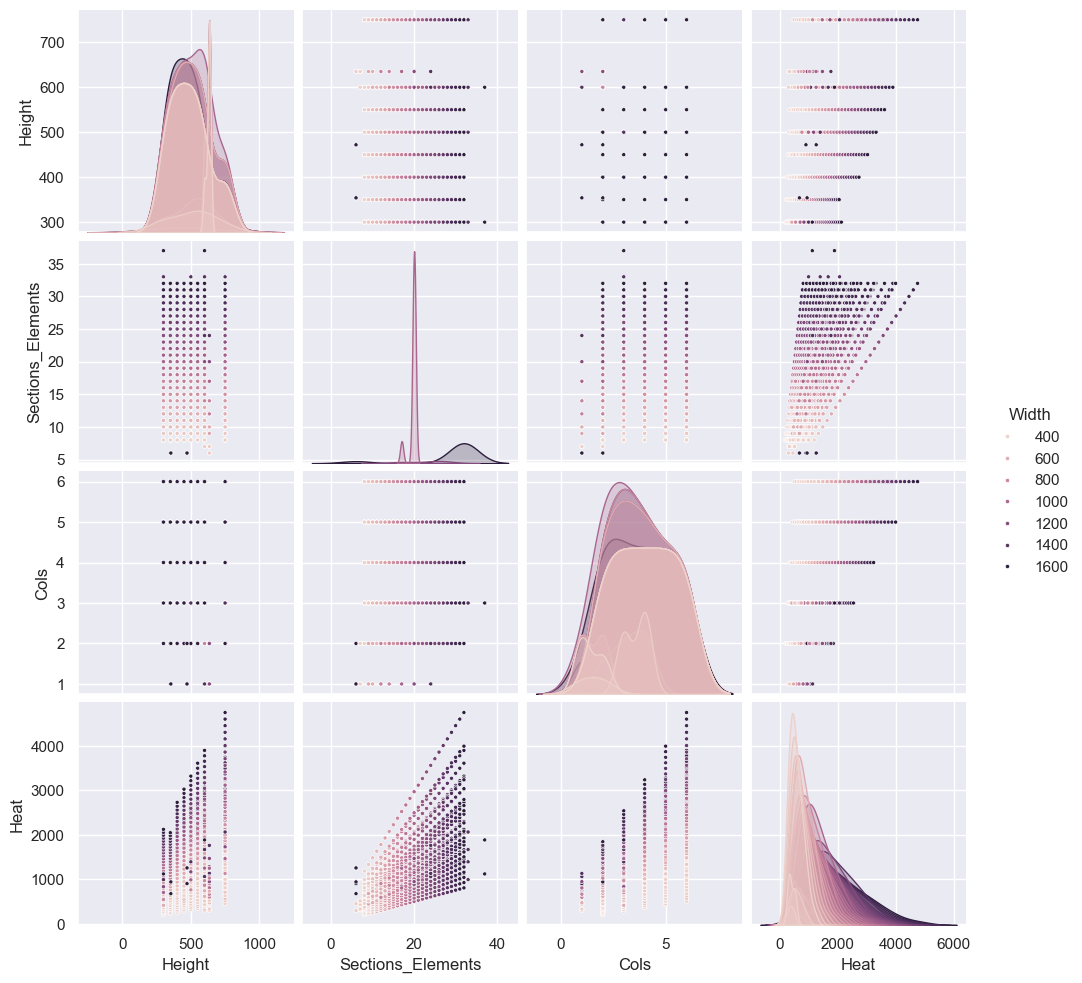

In [67]:
sns.set(rc={'figure.figsize': (14, 8)})
sns.pairplot(df_num, hue='Width', markers=".")
plt.show()

##### Comments

- Again, clearly strong correlation between 'Width' and 'Sections_Elements'
- Interesting 'linear' relationships between width, section_elements and heat.


In [87]:
df = df.drop(['Sections_Elements'], axis = 1)

In [88]:
X = df.drop(['Heat'], axis = 1)
features = list(X.columns)
X = X.values
y = df['Heat'].copy()
y = y.values

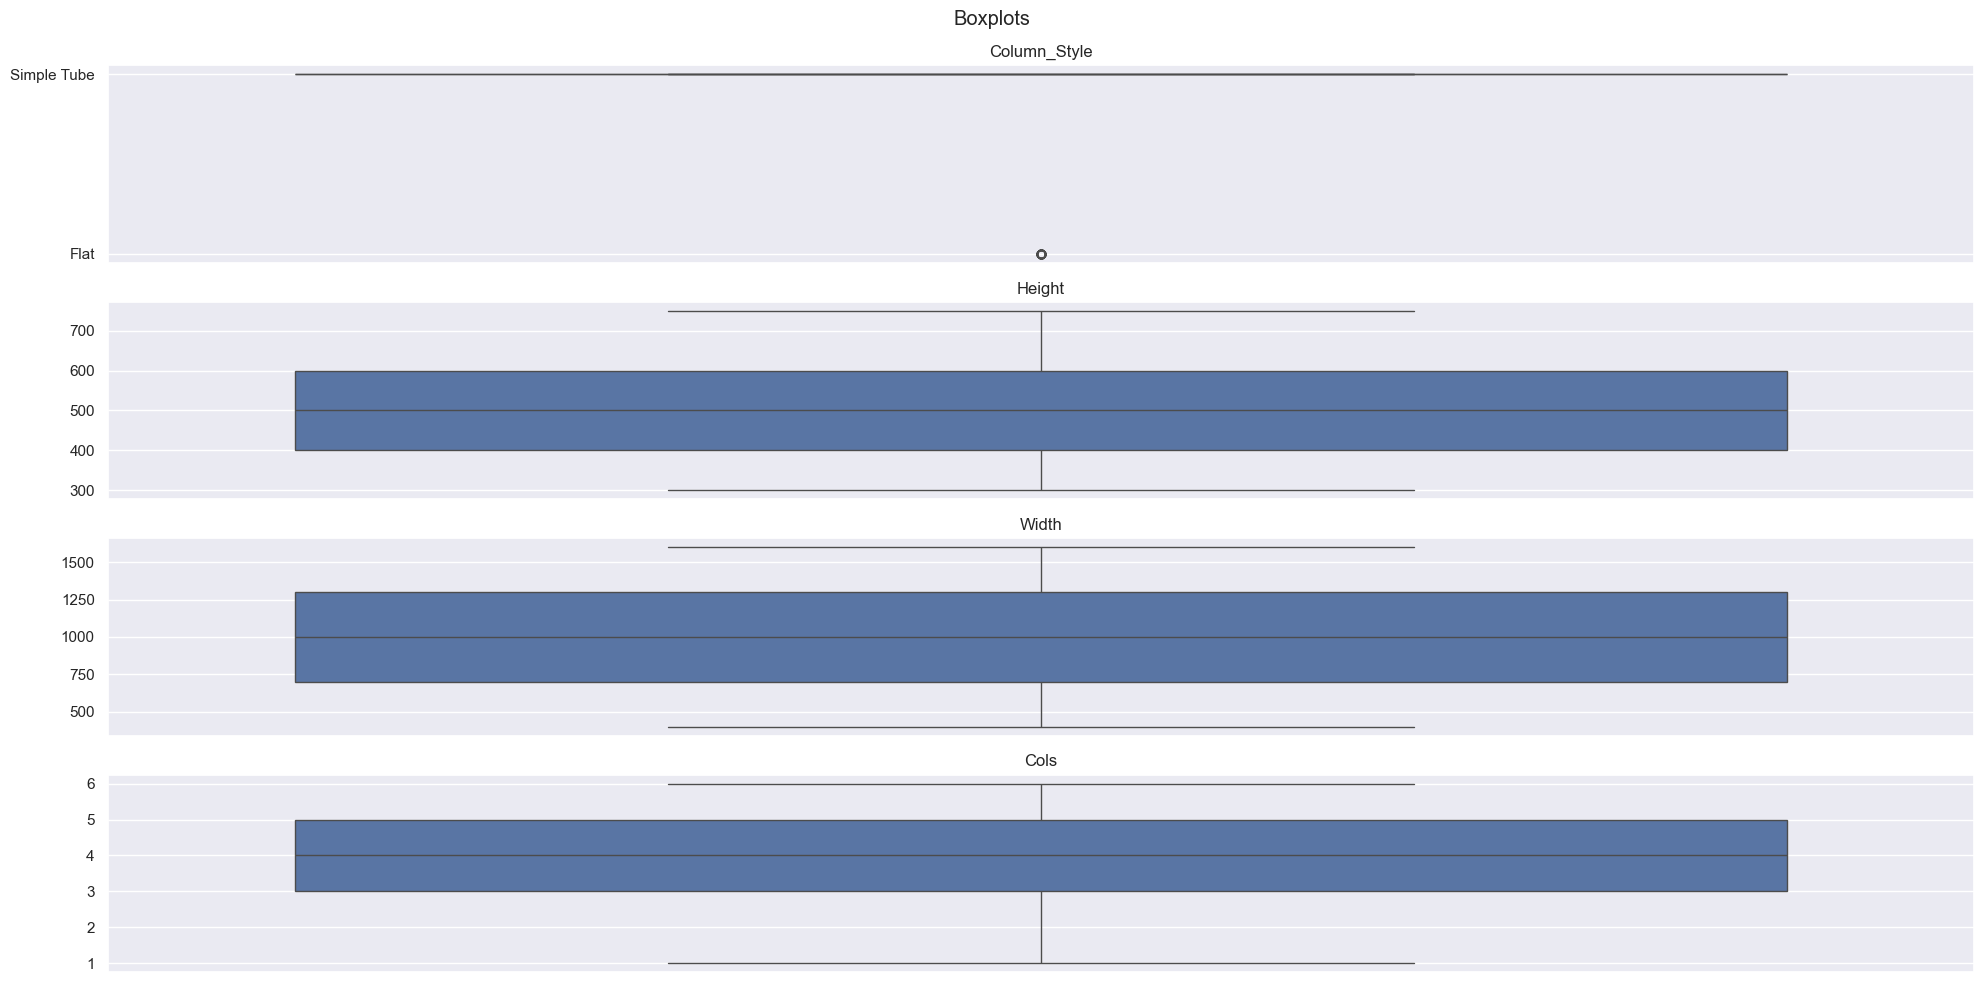

In [71]:
fig, axes = plt.subplots(figsize = (20,10), ncols = 1, nrows = 4, sharex = True)
axes = axes.flatten()

for i, ax in enumerate(axes):
    sns.boxplot(y = X[:,i], ax = ax) 
    ax.set_title(features[i])
    ax.set_ylabel("")
    
plt.suptitle("Boxplots")
plt.tight_layout()
plt.show()

##### Comments

- No clear outliers in data

#### Training test data splits

In [91]:


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
'''
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

X_train.to_csv("X_train.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
y_train.to_csv("y_train.csv", index=False, header=True)
y_test.to_csv("y_test.csv", index=False, header=True)

'''



'\ny_train = pd.DataFrame(y_train)\ny_test = pd.DataFrame(y_test)\nX_train = pd.DataFrame(X_train)\nX_test = pd.DataFrame(X_test)\n\nX_train.to_csv("X_train.csv", index=False)\nX_test.to_csv("X_test.csv", index=False)\ny_train.to_csv("y_train.csv", index=False, header=True)\ny_test.to_csv("y_test.csv", index=False, header=True)\n\n'

In [35]:
X_train = pd.read_csv("X_train.csv")
X_test = pd.read_csv("X_test.csv")

y_train = pd.read_csv("y_train.csv").squeeze("columns")  # Use `squeeze=True` to load as Series
y_test = pd.read_csv("y_test.csv").squeeze("columns")

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values





### Linear Regression Model

In [92]:
def print_evaluation(y_train, y_fit, y_test, y_pred):
    '''Prints the model evaluation.
    '''
    # The mean squared error of the training set 
    print("Training Mean squared error: %.3f" % mean_squared_error(y_train, y_fit))
    # The root mean squared error of the training set 
    print("Training Root-Mean squared error: %.3f" % np.sqrt(mean_squared_error(y_train, y_fit)))
    # The coefficient of determination of the training set 
    print("Training R squared: %.3f" % r2_score(y_train, y_fit))
    
    # The mean squared error of the test set 
    print("Test Mean squared error: %.3f" % mean_squared_error(y_test, y_pred))
    # The root mean squared error of the test set 
    print("Test Root-Mean squared error: %.3f" % np.sqrt(mean_squared_error(y_test, y_pred)))
    # The coefficient of determination of the test set 
    print("Test R squared: %.3f" % r2_score(y_test, y_pred))

In [93]:
def get_coefs(m):
    '''Returns the model coefficients from a Scikit-learn model object as an array,
    includes the intercept if available.
    '''
    # If pipeline, use the last step as the model
    if (isinstance(m, Pipeline)):
        m = m.steps[-1][1]
    
    if m.intercept_ is None:
        return m.coef_
    
    return np.concatenate([[m.intercept_], m.coef_])

In [94]:
def plot_fit(y, y_hat):
    '''Plotting an overview of the model fit including ture vs predicted scores, 
    residuals and a QQ plot
    '''
    res = pd.DataFrame(
        data = {'y': y, 'y_hat': y_hat, 'residual': y - y_hat}
    )
    
    plt.figure(figsize=(12, 3))
    
    plt.subplot(131)
    sns.lineplot(x='y', y='y_hat', color="grey", data =  pd.DataFrame(data={
        'y': [min(y),max(y)], 'y_hat': [min(y),max(y)]}))
    sns.scatterplot(x='y', y='y_hat', data=res).set_title("True vs Predicted ")
    
    plt.subplot(132)
    sns.scatterplot(x='y_hat', y='residual', data=res).set_title("Residuals")
    plt.hlines(y=0, xmin=np.min(y), xmax=np.max(y), linestyles='dashed', alpha=0.3, colors="black")
    
    plt.subplot(133)
    stats.probplot(res['residual'], dist="norm",plot=plt)
    plt.title('Probability Plot of Residuals')
    
    plt.tight_layout()

In [95]:

lin_reg = Pipeline([
        ("pre_processing", ColumnTransformer([
        ("cat_pre", OneHotEncoder(drop='if_binary'), [0]), # Applied to the numerical variables
        ("count_pre", MinMaxScaler(), [1,2,3]), # Applied to the count variables
        ])),
        ('model', LinearRegression(fit_intercept=True))
])


y_train = y_train.reshape(-1,1)
target_scaler  = MinMaxScaler()

y_train_scaled = target_scaler.fit_transform(y_train)



In [96]:

linreg_fit = lin_reg.fit(X_train, y_train_scaled.ravel())

y_pred_scaled = linreg_fit.predict(X_test)
y_fit_scaled = linreg_fit.predict(X_train)

y_fit = target_scaler.inverse_transform(y_fit_scaled.reshape(-1, 1))
y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_fit = y_fit.ravel()
y_pred = y_pred.ravel()

In [97]:
print_evaluation(y_train, y_fit, y_test, y_pred)


Training Mean squared error: 56991.051
Training Root-Mean squared error: 238.728
Training R squared: 0.897
Test Mean squared error: 53670.888
Test Root-Mean squared error: 231.670
Test R squared: 0.893


In [98]:
print(linreg_fit['model'].coef_)
print(linreg_fit['model'].intercept_)

[-0.06821252  0.24235165  0.35958567  0.34051569]
-0.15883373135807513


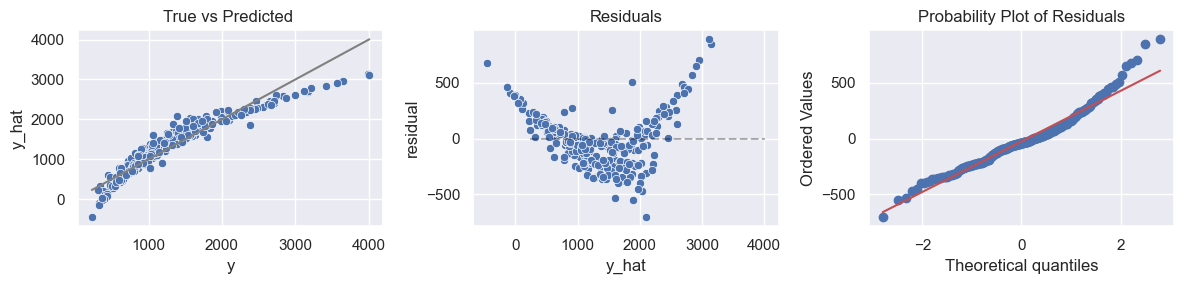

In [99]:
plot_fit(y_test, y_pred)


#### Comments

- It appears that linear model is overpredicting for low values of heat output, and underpredicting for high values of heat output.

### Polynomial Regression Model

From EDA, I've gotten hunch that including interaction term in polynomial expansion between features may suffice for this problem.

In [86]:
pf_interact = PolynomialFeatures(interaction_only=True,include_bias=False)

# Overall ML pipeline

poly_interact_pipe = Pipeline([
        ("pre_processing", ColumnTransformer([
        ("cat_pre", OneHotEncoder(drop='if_binary'), [0]), # Applied to the numerical variables
        ("count_pre", MinMaxScaler(), [1,2,3]), # Applied to the count variables
        ])),
        ('poly_interact', pf_interact),
        ('model', LinearRegression(fit_intercept=True))
])


poly_interact_fit = poly_interact_pipe.fit(X_train, y_train_scaled.ravel())


y_pred_scaled = poly_interact_fit.predict(X_test)
y_fit_scaled = poly_interact_fit.predict(X_train)

y_fit = target_scaler.inverse_transform(y_fit_scaled.reshape(-1, 1))
y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_fit = y_fit.ravel()
y_pred = y_pred.ravel()

In [87]:
print_evaluation(y_train, y_fit, y_test, y_pred)


Training Mean squared error: 5244.250
Training Root-Mean squared error: 72.417
Training R squared: 0.991
Test Mean squared error: 4538.906
Test Root-Mean squared error: 67.371
Test R squared: 0.993


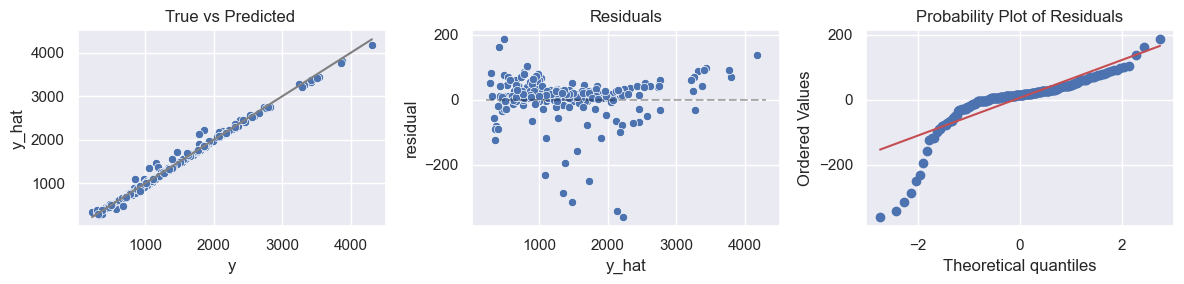

In [88]:
plot_fit(y_test, y_pred)


Much improved, but rmse still significant. R squared looking good. This means that the model captures most of the variability of 'Heat'. However, rmse still significant. Also, loooking at residual plot, we can see that model is far from perfect. It appears to overpredict for low heat values.

#### Polynomial expansion with interaction

In [100]:

pf = PolynomialFeatures()

# Overall ML pipeline
poly_interact_pipe = Pipeline([
        ("pre_processing", ColumnTransformer([
        ("cat_pre", OneHotEncoder(drop='if_binary'), [0]), # Applied to the numerical variables
        ("count_pre", MinMaxScaler(), [1,2,3]), # Applied to the count variables
        ])),
        ('poly', pf),
        ('model', LinearRegression(fit_intercept=True))
])



parameters = {
    'poly__degree': np.arange(1,20,1)
}

kf = KFold(n_splits = 5, shuffle = True, random_state=seed)

grid_search = GridSearchCV(poly_interact_pipe, parameters, cv = kf, scoring = 'neg_mean_squared_error', return_train_score=True).fit(X_train, y_train)

In [101]:
print("best param: ", grid_search.best_params_)
print("best score: ", grid_search.best_score_)
print("coefficents", grid_search.best_estimator_['model'].coef_)

best param:  {'poly__degree': np.int64(3)}
best score:  -8767.6832576107
coefficents [[-3.66499966e-11 -2.90251543e+02 -2.44267130e+03 -9.11011667e+00
   4.54668809e+02 -2.90251543e+02  1.20928385e+03  1.75452035e+02
  -2.18434701e+02  1.96743294e+03  1.89307878e+03  8.88943301e+02
  -1.08402791e+02  2.77564942e+03  3.87054102e+02 -2.90251543e+02
   1.20928385e+03  1.75452035e+02 -2.18434701e+02 -1.46482810e+03
  -1.46616250e+03 -6.45897875e+02  2.05965257e+02 -1.50702507e+03
   2.52433400e+02 -2.05470996e+02 -1.90784195e+02 -1.67664981e+02
   1.50241608e+02  1.66138604e+03  3.71160405e+02 -8.54669271e+01
  -4.43946430e+01 -8.39299249e+01 -3.40638284e+02]]


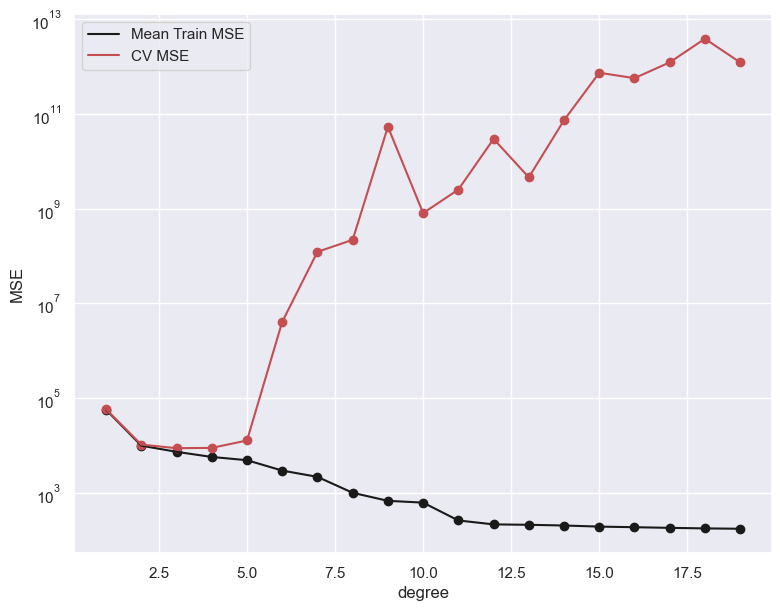

In [102]:
degree = np.arange(1,20,1)
fig, ax = plt.subplots(figsize=(9,7), ncols=1, nrows=1)
plt.scatter(degree,-grid_search.cv_results_['mean_train_score'], color='k')
plt.plot(degree,-grid_search.cv_results_['mean_train_score'], color='k', label='Mean Train MSE')
plt.scatter(degree,-grid_search.cv_results_['mean_test_score'], color='r')
plt.plot(degree,-grid_search.cv_results_['mean_test_score'], color='r', label='CV MSE')
ax.legend()
ax.set_yscale('log')
ax.set_xlabel('degree')
ax.set_ylabel('MSE')
plt.show()

In [103]:
pf = PolynomialFeatures(degree= 3)


poly_interact_pipe_final = Pipeline([
        ("pre_processing", ColumnTransformer([
        ("cat_pre", OneHotEncoder(drop='if_binary'), [0]), # Applied to the numerical variables
        ("count_pre", MinMaxScaler(), [1,2,3]), # Applied to the count variables
        ])),
        ('poly', pf),
        ('model', LinearRegression(fit_intercept=True))
])


poly_interact_fit = poly_interact_pipe_final.fit(X_train, y_train_scaled.ravel())


y_pred_scaled = poly_interact_fit.predict(X_test)
y_fit_scaled = poly_interact_fit.predict(X_train)

y_fit = target_scaler.inverse_transform(y_fit_scaled.reshape(-1, 1))
y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_fit = y_fit.ravel()
y_pred = y_pred.ravel()

In [104]:
print_evaluation(y_train, y_fit, y_test, y_pred)


Training Mean squared error: 7454.385
Training Root-Mean squared error: 86.339
Training R squared: 0.986
Test Mean squared error: 9347.956
Test Root-Mean squared error: 96.685
Test R squared: 0.981


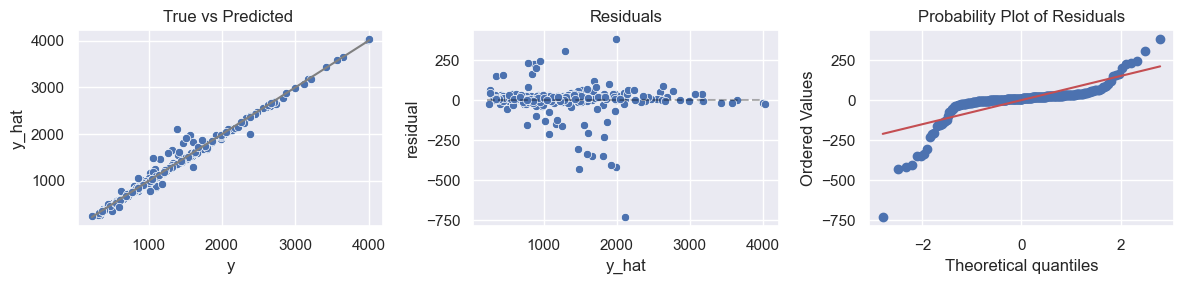

In [ ]:
plot_fit(y_test, y_pred)


Summary Table:
       range  Mean_Percentage_Error
0      0-500                   6.02
1   500-1000                   3.43
2  1000-1500                   5.61
3  1500-2000                   3.88
4  2000-4000                   1.31


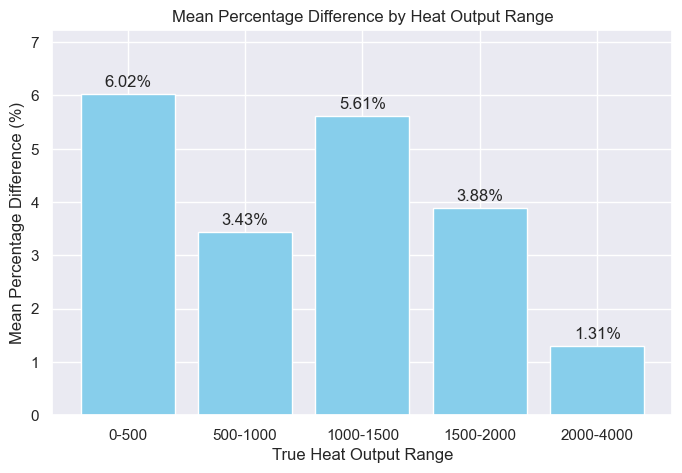

In [106]:
pct_diff = np.abs(y_test - y_pred) / y_test * 100

df_error = pd.DataFrame({
    'y_test': y_test,
    'y_pred': y_pred,
    'pct_diff': pct_diff
})

# Define bins and labels for y_test.
# Adjust bins if your intended ranges differ.
bins = [0, 500, 1000, 1500, 2000, 4000]
labels = ['0-500', '500-1000', '1000-1500', '1500-2000', '2000-4000']

# Bin the y_test values into ranges (using right=False means the bin includes the left edge but excludes the right)
df_error['range'] = pd.cut(df_error['y_test'], bins=bins, right=False, labels=labels)

# Create a summary table: here we compute the mean percentage difference per range.
summary = df_error.groupby('range')['pct_diff'].mean().reset_index()
summary.rename(columns={'pct_diff': 'Mean_Percentage_Error'}, inplace=True)
print("Summary Table:")
print(summary)

# Plotting a bar plot of the mean percentage differences
plt.figure(figsize=(8, 5))
bars = plt.bar(summary['range'], summary['Mean_Percentage_Error'], color='skyblue')
plt.xlabel('True Heat Output Range')
plt.ylabel('Mean Percentage Difference (%)')
plt.title('Mean Percentage Difference by Heat Output Range')
plt.ylim(0, summary['Mean_Percentage_Error'].max() * 1.2)  # add a little headroom on the y-axis



# Annotate each bar with the mean percentage error values
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.2f}%',  # Format value to 2 decimal places followed by a percent sign
                 xy=(bar.get_x() + bar.get_width() / 2, height),  # Position at the center top of the bar
                 xytext=(0, 3),  # Offset text by 3 points above the bar
                 textcoords="offset points",
                 ha='center', va='bottom')

plt.show()


Experiment

In [46]:

pf = PolynomialFeatures()
pf_interact = PolynomialFeatures(interaction_only=True)


# Overall ML pipeline
poly_interact_pipe = Pipeline([("min_max", MinMaxScaler()), 
                               ('p_interact', pf_interact),
                               ('p_degrees', ColumnTransformer([
                                   ('poly_1', pf, [0]),
                                   ('poly_2', pf, [1]),
                                   ('poly_3', pf, [2]),
                                   ('poly_4', pf, [3])])),
                               ('model', LinearRegression())])




parameters = {
    'p_degrees__poly_1__degree': np.arange(1,15,1),
    'p_degrees__poly_2__degree': np.arange(1,15,1),
    'p_degrees__poly_3__degree': np.arange(1,15,1),
    'p_degrees__poly_4__degree': np.arange(1,15,1)
}

kf = KFold(n_splits = 5, shuffle = True, random_state=seed)

grid_search = GridSearchCV(poly_interact_pipe, parameters, cv = kf, scoring = 'neg_mean_squared_error', return_train_score=True).fit(X_train, y_train)

KeyboardInterrupt: 

In [131]:
print("best param: ", grid_search.best_params_)
print("best score: ", grid_search.best_score_)


best param:  {'p_degrees__poly_1__degree': np.int64(6), 'p_degrees__poly_2__degree': np.int64(1), 'p_degrees__poly_3__degree': np.int64(9), 'p_degrees__poly_4__degree': np.int64(6)}
best score:  -405601.6266983473


#### Tests with Standard Error

In [107]:
def error_using_se(pipeline,X_train,y_train_scaled,X_new, target_scaler,alpha = 0.05):
    percentile = (1 - alpha)*100

    X_train_trans = pipeline[:-1].transform(X_train)


    # Add a constant to the design matrix
    X_train_trans = sm.add_constant(X_train_trans)

    # Fit the OLS model using statsmodels.
    ols_model = sm.OLS(y_train_scaled.ravel(), X_train_trans)
    results = ols_model.fit()

    cov_beta = results.cov_params()       # Covariance matrix of the coefficients
    sigma2 = results.mse_resid            # Residual variance

    # transform X_new
    X_new_trans = pipeline[:-1].transform(X_new)


    # For each new observation, compute the variance of prediction.
    # We'll store the standard errors in a list:
    var_pred = np.dot(X_new_trans, np.dot(cov_beta, X_new_trans.T)) + sigma2
    se_pred = np.sqrt(var_pred)

    # Degrees of freedom: n - p, where n is the number of training samples
    deg_freedom = results.df_resid  
    t_val = t.ppf(1-(alpha/2), deg_freedom)  # two-tailed 95% confidence

    # Suppose you also compute the point predictions for X_new:
    y_new_pred_scaled = results.predict(X_new_trans)

    lower_bounds_scaled = y_new_pred_scaled - t_val * se_pred
    upper_bounds_scaled = y_new_pred_scaled + t_val * se_pred

    y_new_pred = target_scaler.inverse_transform(y_new_pred_scaled.reshape(-1, 1))
    lower_bounds = target_scaler.inverse_transform(lower_bounds_scaled.reshape(-1, 1))
    upper_bounds = target_scaler.inverse_transform(upper_bounds_scaled.reshape(-1, 1))
    print(f"Output = {y_new_pred}")
    print(f"Lower {percentile} percentile = {lower_bounds}")
    print(f"Upper {percentile} percentile = {upper_bounds}")

    
    return y_new_pred, lower_bounds, upper_bounds


##### Low heat output 

In [108]:
d_low = df.loc[df.Height == 300]
d_low = d_low.loc[d_low.Cols == 3]
d_low = d_low.loc[400 < d_low.Width]
d_low = d_low.loc[d_low.Width < 600]
d_low

,Column_Style,Height,Width,Cols,Heat
255,Simple Tube,300,444,3.00,288.00
1284,Simple Tube,300,450,3.00,319.00
1285,Simple Tube,300,500,3.00,354.00
1286,Simple Tube,300,550,3.00,389.00


In [109]:
X_low = np.array([['Simple Tube', 300.,500.,3.]])
y_low = 354

y_new_pred, lower_bounds, upper_bounds = error_using_se(poly_interact_pipe_final,X_train,y_train_scaled,X_low, target_scaler)

Output = [[353.69420612]]
Lower 95.0 percentile = [[179.461868]]
Upper 95.0 percentile = [[527.92654425]]


In [ ]:
X_low = np.array([['Simple Tube', 300.,520.,3.]])

y_new_pred, lower_bounds, upper_bounds = error_using_se(poly_interact_pipe_final,X_train,y_train_scaled,X_low, target_scaler)

Output = [[379.7197627]]
Lower 95.0 percentile = [[266.36754366]]
Upper 95.0 percentile = [[493.07198174]]


In [ ]:
X_low = np.array([['Simple Tube',300.,450.,3.]])

y_new_pred, lower_bounds, upper_bounds = error_using_se(poly_interact_pipe_final,X_train,y_train_scaled,X_low, target_scaler)

Output = [[329.63622955]]
Lower 95.0 percentile = [[215.111132]]
Upper 95.0 percentile = [[444.16132709]]


##### Bootstrap

In [96]:

def bootstrap_results(pipeline, X, y, X_new, n_bootstraps, percentile, seed):
    """
    Estimate prediction intervals for X_new by bootstrapping the training data.
    
    Parameters:
    - pipeline: the scikit-learn pipeline (already defined)
    - X, y: datasets used for bootstrapping
    - X_new: new data for which to estimate prediction intervals
    - n_bootstraps: number of bootstrap samples
    - percentile: confidence level (e.g., 95 for a 95% interval)
    
    Returns:
    - lower: lower bound for each prediction
    - upper: upper bound for each prediction
    """
    all_predictions = np.zeros(n_bootstraps)
    
    for _ in range(n_bootstraps):
        # Sample indices with replacement
        X_train_boot, X_test_boot, y_train_boot, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

        # Clone the pipeline so that each bootstrap fit is independent
        pipeline_clone = clone(pipeline)
        pipeline_clone.fit(X_train_boot, y_train_boot)
        
        # Record predictions for X_new (in the scaled space if needed)
        preds = pipeline_clone.predict(X_new)
        all_predictions[_] = preds
    
    # Convert list to array: shape (n_bootstraps, n_new_samples)
    mean = np.mean(all_predictions)
    std = np.std(all_predictions)

    # Compute lower and upper percentiles for each new sample
    lower_percentile = (100 - percentile) / 2
    upper_percentile = 100 - lower_percentile
    
    lower = np.percentile(all_predictions, lower_percentile, axis=0)
    upper = np.percentile(all_predictions, upper_percentile, axis=0)

    fig, axes = plt.subplots(1, 1, figsize=(18, 5))
    sns.histplot(all_predictions, color="royalblue", kde=True)

    print(f"Lower {percentile} percentile = {lower}")
    print(f"Upper {percentile} percentile = {upper}")
    print(f"Mean Heat Output = {mean}")
    print(f"Standard Deviation Heat Output = {std}")
    
    return all_predictions


Lower 95 percentile = 4824.576266620107
Upper 95 percentile = 4824.576266620107
Mean Heat Output = 4824.576266620107
Standard Deviation Heat Output = 0.0


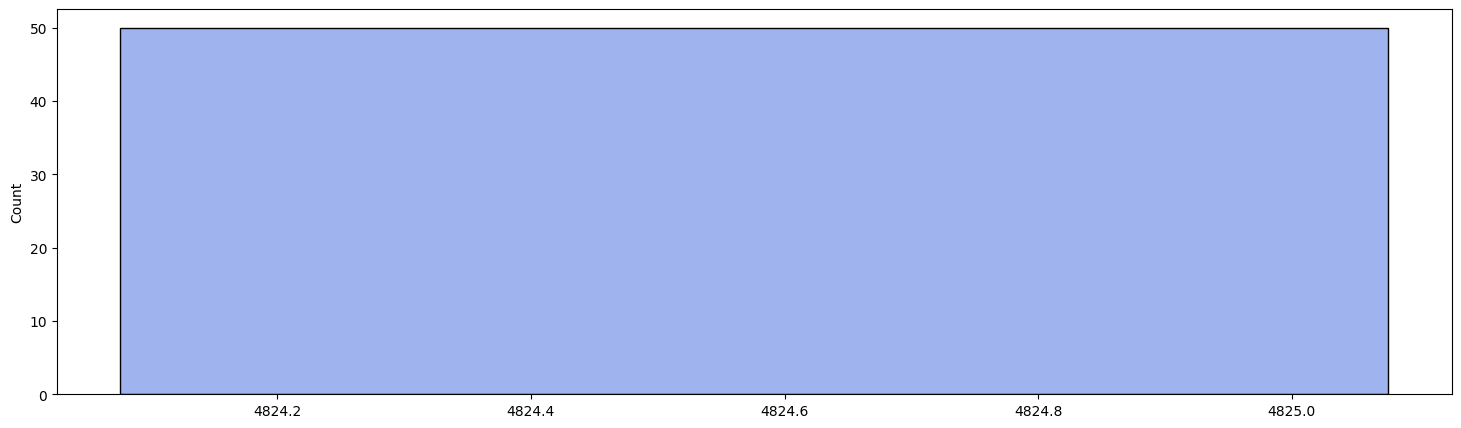

In [101]:
X_new = np.array([[1000.,1500.,5.]])
n_bootstraps = 1000
percentile = 95


all_predictions = bootstrap_results(poly_interact_pipe_12, X, y, X_new, n_bootstraps, percentile, seed)

Lower 95 percentile = 5146.022253840908
Upper 95 percentile = 5146.022253840908
Mean Heat Output = 5146.022253840907
Standard Deviation Heat Output = 9.094947017729282e-13


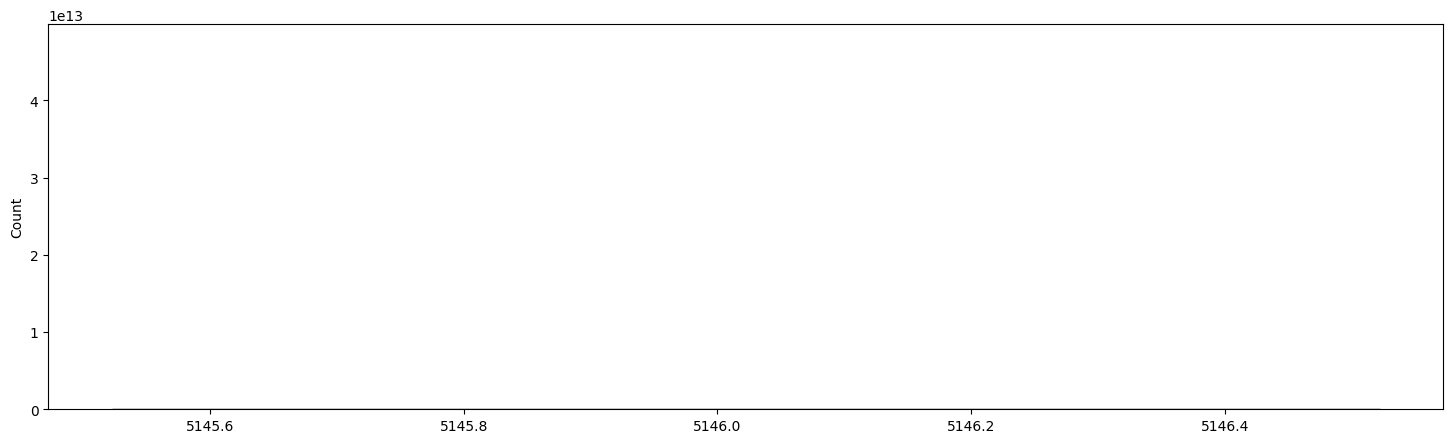

In [103]:
X_new = np.array([[1000.,1600.,5.]])
n_bootstraps = 50
percentile = 95


all_predictions = bootstrap_results(poly_interact_pipe_12, X, y, X_new, n_bootstraps, percentile, seed)

Comments about going forward

- How do we want to quantify error?
- More data?